<a href="https://colab.research.google.com/github/everestso/Summer24/blob/main/ResidualNetworks1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Run this if you're in a Colab to install MNIST 1D repository
!pip install git+https://github.com/greydanus/mnist1d

  Cloning https://github.com/greydanus/mnist1d to /tmp/pip-req-build-390sbrgc
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d /tmp/pip-req-build-390sbrgc
  Resolved https://github.com/greydanus/mnist1d to commit 350929d12f4c9a4b7355e0c96604e41b9239bdb4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mnist1d: filename=mnist1d-0.0.2.post9-py3-none-any.whl size=14497 sha256=c24d9c9cb8dda04791ce284ab68bfc4e74df11e72acf23b5813d3aab7f9c89de
  Stored in directory: /tmp/pip-ephem-wheel-cache-zvdapdv4/wheels/41/95/55/45fcf7d38cfa97e35682da6c5017d4513729131326ce935371
Successfully built mnist1d


In [2]:
import numpy as np
import os
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import mnist1d
import random

In [3]:
args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=False)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40


In [14]:
# Load in the data
train_data_x = data['x'].transpose()
train_data_y = data['y']
val_data_x = data['x_test'].transpose()
val_data_y = data['y_test']
# Print out sizes
print("Train data: %d examples (columns), each of which has %d dimensions (rows)"%((train_data_x.shape[1],train_data_x.shape[0])))
print("Validation data: %d examples (columns), each of which has %d dimensions (rows)"%((val_data_x.shape[1],val_data_x.shape[0])))

# convert data to torch tensors
x_train = torch.tensor(train_data_x.transpose().astype('float32'))
y_train = torch.tensor(train_data_y.astype('long'))
x_val= torch.tensor(val_data_x.transpose().astype('float32'))
y_val = torch.tensor(val_data_y.astype('long'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

# There are 40 input dimensions and 10 output dimensions for this data
# The inputs correspond to the 40 offsets in the MNIST1D template.
D_i = 40
# The outputs correspond to the 10 digits
D_o = 10

Train data: 4000 examples (columns), each of which has 40 dimensions (rows)
Validation data: 1000 examples (columns), each of which has 40 dimensions (rows)


In [5]:
# We will adapt this model to have residual connections around the linear layers
# This is the same model we used in practical 8.1, but we can't use the sequential
# class for residual networks (which aren't strictly sequential).  Hence, I've rewritten
# it as a model that inherits from a base class

class BaseNetwork(torch.nn.Module):
  def __init__(self, input_size, output_size, hidden_size=100):
    super(BaseNetwork, self).__init__()
    self.linear1 = nn.Linear(input_size, hidden_size)
    self.linear2 = nn.Linear(hidden_size, hidden_size)
    self.linear3 = nn.Linear(hidden_size, hidden_size)
    self.linear4 = nn.Linear(hidden_size, output_size)
    print("Initialized MLPBase model with {} parameters".format(self.count_params()))

  def count_params(self):
    return sum([p.view(-1).shape[0] for p in self.parameters()])

# TODO -- Add residual connections to this model
# The order of operations within each block should similar to figure 11.5b
# ie., linear1 first, ReLU+linear2 in first residual block, ReLU+linear3 in second residual block), linear4 at end
# Replace this function
  def forward(self, x):
    h1 = self.linear1(x).relu()
    h2 = self.linear2(h1).relu()
    h3 = self.linear3(h2).relu()
    return self.linear4(h3)


In [6]:
# prompt: # TODO -- Add residual connections to this model
# # The order of operations within each block should similar to figure 11.5b
# # ie., linear1 first, ReLU+linear2 in first residual block, ReLU+linear3 in second residual block), linear4 at end
# # Replace this function
#   def forward(self, x):
#     h1 = self.linear1(x).relu()
#     h2 = self.linear2(h1).relu()
#     h3 = self.linear3(h2).relu()
#     return self


# We will adapt this model to have residual connections around the linear layers
# This is the same model we used in practical 8.1, but we can't use the sequential
# class for residual networks (which aren't strictly sequential).  Hence, I've rewritten
# it as a model that inherits from a base class

class ResidualNetwork(torch.nn.Module):
  def __init__(self, input_size, output_size, hidden_size=100):
    super(ResidualNetwork, self).__init__()
    self.linear1 = nn.Linear(input_size, hidden_size)
    self.linear2 = nn.Linear(hidden_size, hidden_size)
    self.linear3 = nn.Linear(hidden_size, hidden_size)
    self.linear4 = nn.Linear(hidden_size, output_size)
    print("Initialized MLPBase model with {} parameters".format(self.count_params()))

  def count_params(self):
    return sum([p.view(-1).shape[0] for p in self.parameters()])

  def forward(self, x):
    h1 = self.linear1(x).relu()
    h2 = self.linear2(h1).relu() + h1 # residual connection
    h3 = self.linear3(h2).relu() + h2 # residual connection
    return self.linear4(h3)


In [7]:

## https://github.com/greydanus/mnist1d
# prompt: Modify previous model to include batch normalization.

class ResidualNetwork_Batch(torch.nn.Module):
  def __init__(self, input_size, output_size, hidden_size=100):
    super(ResidualNetwork_Batch, self).__init__()
    self.linear1 = nn.Linear(input_size, hidden_size)
    self.bn1 = nn.BatchNorm1d(hidden_size) # batch normalization after first linear layer
    self.linear2 = nn.Linear(hidden_size, hidden_size)
    self.bn2 = nn.BatchNorm1d(hidden_size) # batch normalization after second linear layer
    self.linear3 = nn.Linear(hidden_size, hidden_size)
    self.bn3 = nn.BatchNorm1d(hidden_size) # batch normalization after third linear layer
    self.linear4 = nn.Linear(hidden_size, output_size)
    print("Initialized MLPBase model with {} parameters".format(self.count_params()))

  def count_params(self):
    return sum([p.view(-1).shape[0] for p in self.parameters()])

  def forward(self, x):
    h1 = self.bn1(self.linear1(x)).relu() # batch normalization after first linear layer
    h2 = self.bn2(self.linear2(h1)).relu() + h1 # batch normalization after second linear layer, residual connection
    h3 = self.bn3(self.linear3(h2)).relu() + h2 # batch normalization after third linear layer, residual connection
    return self.linear4(h3)


In [8]:

## https://github.com/greydanus/mnist1d
# prompt: Modify previous model to include batch normalization.

# There are 40 input dimensions and 10 output dimensions for this data
# The inputs correspond to the 40 offsets in the MNIST1D template.
D_i = 40
# The outputs correspond to the 10 digits
D_o = 10

class ResidualNetwork_CNN(torch.nn.Module):
  def __init__(self, input_size, output_size, hidden_size=100):
    super(ResidualNetwork_CNN, self).__init__()
    self.linear1 = nn.Linear(input_size, hidden_size)
    self.bn1 = nn.BatchNorm1d(hidden_size) # batch normalization after first linear layer
    self.linear2 = nn.Linear(hidden_size, hidden_size)
    self.bn2 = nn.BatchNorm1d(hidden_size) # batch normalization after second linear layer
    self.linear3 = nn.Linear(hidden_size, hidden_size)
    self.bn3 = nn.BatchNorm1d(hidden_size) # batch normalization after third linear layer
    self.linear4 = nn.Linear(hidden_size, output_size)
    print("Initialized MLPBase model with {} parameters".format(self.count_params()))

  def count_params(self):
    return sum([p.view(-1).shape[0] for p in self.parameters()])

  def forward(self, x):
    h1 = self.bn1(self.linear1(x)).relu() # batch normalization after first linear layer
    h2 = self.bn2(self.linear2(h1)).relu() + h1 # batch normalization after second linear layer, residual connection
    h3 = self.bn3(self.linear3(h2)).relu() + h2 # batch normalization after third linear layer, residual connection
    return self.linear4(h3)


In [9]:
# prompt: Modify the network model to include batch normalization
# There are 40 input dimensions and 10 output dimensions for this data
# The inputs correspond to the 40 offsets in the MNIST1D template.
D_i = 40
# The outputs correspond to the 10 digits
D_o = 10

class ResidualNetwork_CNNbatch(torch.nn.Module):
  def __init__(self, input_size, output_size, hidden_size=100):
    super(ResidualNetwork_CNNbatch, self).__init__()
    self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm1d(16)  # Batch normalization after conv1
    self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm1d(32)  # Batch normalization after conv2
    self.linear1 = nn.Linear(input_size*32, hidden_size)
    self.bn3 = nn.BatchNorm1d(hidden_size)  # Batch normalization after linear1
    self.linear2 = nn.Linear(hidden_size, hidden_size)
    self.bn4 = nn.BatchNorm1d(hidden_size)  # Batch normalization after linear2
    self.linear3 = nn.Linear(hidden_size, hidden_size)
    self.bn5 = nn.BatchNorm1d(hidden_size)  # Batch normalization after linear3
    self.linear4 = nn.Linear(hidden_size, output_size)
    print("Initialized MLPBase model with {} parameters".format(self.count_params()))

  def count_params(self):
    return sum([p.view(-1).shape[0] for p in self.parameters()])

  def forward(self, x):
    # assuming x is of shape (batch_size, 1, 40)
    x = x.unsqueeze(1)  # add a channel dimension
    x = self.bn1(self.conv1(x).relu())  # Batch normalization after conv1 and ReLU
    x = self.bn2(self.conv2(x).relu())  # Batch normalization after conv2 and ReLU
    x = x.view(x.size(0), -1)  # flatten the tensor
    h1 = self.bn3(self.linear1(x).relu())  # Batch normalization after linear1 and ReLU
    h2 = self.bn4(self.linear2(h1).relu()) + h1 # residual connection and batch normalization
    h3 = self.bn5(self.linear3(h2).relu()) + h2 # residual connection and batch normalization
    return self.linear4(h3)


In [10]:
# He initialization of weights
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

In [18]:
# prompt: Rewrite as function, and then call function with results of previous training of model: # Plot the results
# fig, ax = plt.subplots()
# ax.plot(errors_train,'r-',label='train')
# ax.plot(errors_val,'b-',label='test')
# ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
# ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
# ax.set_title('TrainError %3.2f, Val Error %3.2f'%(errors_train[-1],errors_val[-1]))
# ax.legend()
# plt

def plot_results(errors_train, errors_val, n_epoch, title=""): # Added title parameter
  # Plot the results
  fig, ax = plt.subplots()
  ax.plot(errors_train,'r-',label='train')
  ax.plot(errors_val,'b-',label='test')
  ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
  ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
  ax.set_title(title + ': TrainError %3.2f, Val Error %3.2f'%(errors_train[-1],errors_val[-1])) # Added title to the plot title
  ax.legend()
  plt.show()

In [12]:
# prompt: Rewrite the previous block so it can be called with multiple models.

# loop over the dataset n_epoch times
n_epoch = 100

def train_model(model, optimizer, scheduler, data_loader, x_train, y_train, x_val, y_val, n_epoch=100):
    # store the loss and the % correct at each epoch
    losses_train = np.zeros((n_epoch))
    errors_train = np.zeros((n_epoch))
    losses_val = np.zeros((n_epoch))
    errors_val = np.zeros((n_epoch))

    for epoch in range(n_epoch):
        # loop over batches
        for i, data in enumerate(data_loader):
            # retrieve inputs and labels for this batch
            x_batch, y_batch = data
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward pass -- calculate model output
            pred = model(x_batch)
            # compute the loss
            loss = loss_function(pred, y_batch)
            # backward pass
            loss.backward()
            # SGD update
            optimizer.step()

        # Run whole dataset to get statistics -- normally wouldn't do this
        pred_train = model(x_train)
        pred_val = model(x_val)
        _, predicted_train_class = torch.max(pred_train.data, 1)
        _, predicted_val_class = torch.max(pred_val.data, 1)
        errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
        errors_val[epoch]= 100 - 100 * (predicted_val_class == y_val).float().sum() / len(y_val)
        losses_train[epoch] = loss_function(pred_train, y_train).item()
        losses_val[epoch]= loss_function(pred_val, y_val).item()
        print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  val loss {losses_val[epoch]:.6f}, percent error {errors_val[epoch]:3.2f}')

        # tell scheduler to consider updating learning rate
        scheduler.step()

    return losses_train, errors_train, losses_val, errors_val


Initialized MLPBase model with 25310 parameters
Epoch     0, train loss 1.632430, train error 64.40,  val loss 1.684772, percent error 67.10
Epoch     1, train loss 1.347874, train error 51.65,  val loss 1.457525, percent error 58.10
Epoch     2, train loss 1.170454, train error 43.53,  val loss 1.342219, percent error 52.50
Epoch     3, train loss 1.049855, train error 39.67,  val loss 1.278449, percent error 51.30
Epoch     4, train loss 0.839953, train error 31.12,  val loss 1.171054, percent error 45.70
Epoch     5, train loss 0.771480, train error 29.38,  val loss 1.142531, percent error 43.50
Epoch     6, train loss 0.675497, train error 24.70,  val loss 1.092627, percent error 41.20
Epoch     7, train loss 0.532540, train error 18.60,  val loss 1.097703, percent error 41.40
Epoch     8, train loss 0.503725, train error 16.78,  val loss 1.158808, percent error 42.30
Epoch     9, train loss 0.489853, train error 16.60,  val loss 1.195637, percent error 44.00
Epoch    10, train los

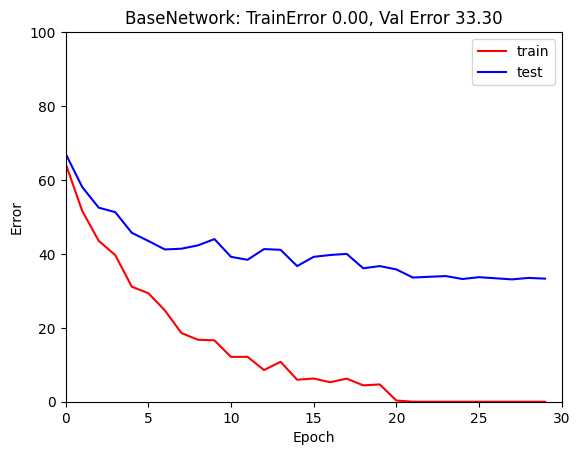

In [20]:
# prompt: Write code to call train_model with model Base network.

#Define the model
n_epoch = 30
model = BaseNetwork(40, 10)
# choose cross entropy loss function (equation 5.24 in the loss notes)
loss_function = nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)
# object that decreases learning rate by half every 20 epochs
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

# Initialize model weights
model.apply(weights_init)

losses_train, errors_train, losses_val, errors_val = train_model(model, optimizer, scheduler, data_loader, x_train, y_train, x_val, y_val, n_epoch)

# Call the function with the results from the previous training
plot_results(errors_train, errors_val, n_epoch, "BaseNetwork")


Initialized MLPBase model with 151638 parameters
Epoch     0, train loss 1.197036, train error 47.58,  val loss 1.287490, percent error 50.90
Epoch     1, train loss 0.674705, train error 27.45,  val loss 0.921988, percent error 37.00
Epoch     2, train loss 0.472636, train error 17.72,  val loss 0.733890, percent error 27.40
Epoch     3, train loss 0.265814, train error 10.25,  val loss 0.545700, percent error 20.90
Epoch     4, train loss 0.184228, train error 6.55,  val loss 0.469851, percent error 18.50
Epoch     5, train loss 0.110124, train error 3.68,  val loss 0.409882, percent error 14.30
Epoch     6, train loss 0.074236, train error 2.32,  val loss 0.441817, percent error 14.10
Epoch     7, train loss 0.030436, train error 0.78,  val loss 0.352013, percent error 11.80
Epoch     8, train loss 0.019967, train error 0.38,  val loss 0.347213, percent error 10.00
Epoch     9, train loss 0.007393, train error 0.03,  val loss 0.284453, percent error 8.90
Epoch    10, train loss 0.00

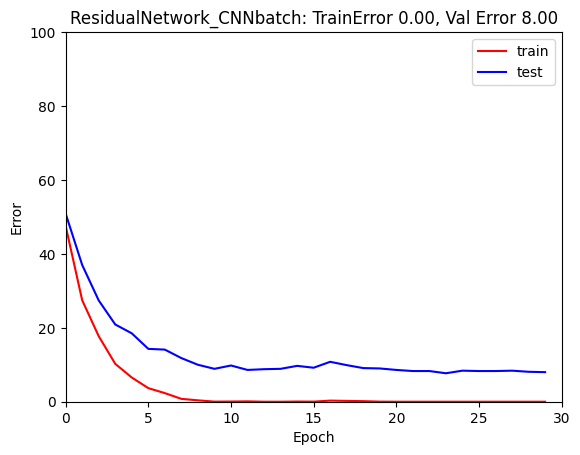

In [21]:
# prompt: Write code to call train_model with model Base network.

#Define the model
n_epoch = 30
model = ResidualNetwork_CNNbatch(40, 10)
# choose cross entropy loss function (equation 5.24 in the loss notes)
loss_function = nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)
# object that decreases learning rate by half every 20 epochs
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

# Initialize model weights
model.apply(weights_init)

losses_train, errors_train, losses_val, errors_val = train_model(model, optimizer, scheduler, data_loader, x_train, y_train, x_val, y_val, n_epoch)

# Call the function with the results from the previous training
plot_results(errors_train, errors_val, n_epoch, "ResidualNetwork_CNNbatch")


Initialized MLPBase model with 25310 parameters
Epoch     0, train loss 1.579574, train error 62.33,  val loss 1.651631, percent error 67.20
Epoch     1, train loss 1.311252, train error 47.80,  val loss 1.436451, percent error 55.80
Epoch     2, train loss 1.094014, train error 39.40,  val loss 1.317759, percent error 51.40
Epoch     3, train loss 0.965585, train error 34.90,  val loss 1.229459, percent error 47.50
Epoch     4, train loss 0.846939, train error 29.60,  val loss 1.206501, percent error 47.40
Epoch     5, train loss 0.744987, train error 27.68,  val loss 1.172917, percent error 43.50
Epoch     6, train loss 0.619036, train error 21.88,  val loss 1.154418, percent error 42.10
Epoch     7, train loss 0.553268, train error 19.55,  val loss 1.134754, percent error 40.80
Epoch     8, train loss 0.456547, train error 15.45,  val loss 1.123027, percent error 40.40
Epoch     9, train loss 0.433489, train error 15.15,  val loss 1.232245, percent error 41.80
Epoch    10, train los

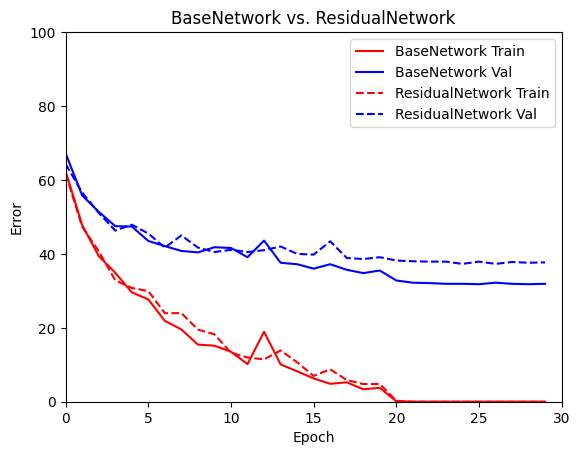

In [22]:
# prompt: Generate Single Plot with Base Model, BaseModel w/ Residuals

# Train BaseNetwork
n_epoch = 30
model_base = BaseNetwork(40, 10)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_base.parameters(), lr=0.05, momentum=0.9)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
model_base.apply(weights_init)
losses_train_base, errors_train_base, losses_val_base, errors_val_base = train_model(model_base, optimizer, scheduler, data_loader, x_train, y_train, x_val, y_val, n_epoch)

# Train ResidualNetwork
model_residual = ResidualNetwork(40, 10)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_residual.parameters(), lr=0.05, momentum=0.9)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
model_residual.apply(weights_init)
losses_train_residual, errors_train_residual, losses_val_residual, errors_val_residual = train_model(model_residual, optimizer, scheduler, data_loader, x_train, y_train, x_val, y_val, n_epoch)

# Plot results on a single plot
fig, ax = plt.subplots()
ax.plot(errors_train_base, 'r-', label='BaseNetwork Train')
ax.plot(errors_val_base, 'b-', label='BaseNetwork Val')
ax.plot(errors_train_residual, 'r--', label='ResidualNetwork Train')
ax.plot(errors_val_residual, 'b--', label='ResidualNetwork Val')
ax.set_ylim(0, 100); ax.set_xlim(0, n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('BaseNetwork vs. ResidualNetwork')
ax.legend()
plt.show()


Initialized MLPBase model with 25310 parameters
Epoch     0, train loss 1.556570, train error 61.30,  val loss 1.634036, percent error 68.20
Epoch     1, train loss 1.369203, train error 54.28,  val loss 1.473636, percent error 60.10
Epoch     2, train loss 1.195534, train error 45.97,  val loss 1.375338, percent error 55.40
Epoch     3, train loss 1.014563, train error 36.50,  val loss 1.270071, percent error 49.10
Epoch     4, train loss 0.850927, train error 30.40,  val loss 1.192541, percent error 46.20
Epoch     5, train loss 0.730472, train error 25.20,  val loss 1.123299, percent error 44.20
Epoch     6, train loss 0.694630, train error 25.12,  val loss 1.184959, percent error 44.40
Epoch     7, train loss 0.591673, train error 21.65,  val loss 1.159125, percent error 43.10
Epoch     8, train loss 0.514799, train error 18.35,  val loss 1.129673, percent error 41.50
Epoch     9, train loss 0.379782, train error 12.65,  val loss 1.076389, percent error 40.20
Epoch    10, train los

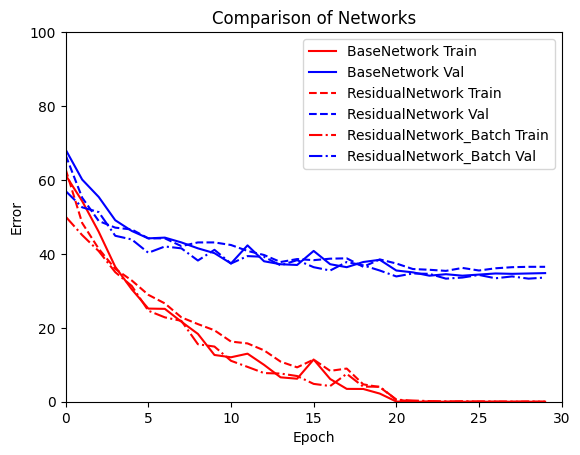

In [23]:
# prompt: Generate plot w/ BaseNetwork, Residual Network, and Residual Network w/ Batch

# Train BaseNetwork
n_epoch = 30
model_base = BaseNetwork(40, 10)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_base.parameters(), lr=0.05, momentum=0.9)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
model_base.apply(weights_init)
losses_train_base, errors_train_base, losses_val_base, errors_val_base = train_model(model_base, optimizer, scheduler, data_loader, x_train, y_train, x_val, y_val, n_epoch)

# Train ResidualNetwork
model_residual = ResidualNetwork(40, 10)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_residual.parameters(), lr=0.05, momentum=0.9)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
model_residual.apply(weights_init)
losses_train_residual, errors_train_residual, losses_val_residual, errors_val_residual = train_model(model_residual, optimizer, scheduler, data_loader, x_train, y_train, x_val, y_val, n_epoch)

# Train ResidualNetwork_Batch
model_batch = ResidualNetwork_Batch(40, 10)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_batch.parameters(), lr=0.05, momentum=0.9)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
model_batch.apply(weights_init)
losses_train_batch, errors_train_batch, losses_val_batch, errors_val_batch = train_model(model_batch, optimizer, scheduler, data_loader, x_train, y_train, x_val, y_val, n_epoch)

# Plot results on a single plot
fig, ax = plt.subplots()
ax.plot(errors_train_base, 'r-', label='BaseNetwork Train')
ax.plot(errors_val_base, 'b-', label='BaseNetwork Val')
ax.plot(errors_train_residual, 'r--', label='ResidualNetwork Train')
ax.plot(errors_val_residual, 'b--', label='ResidualNetwork Val')
ax.plot(errors_train_batch, 'r-.', label='ResidualNetwork_Batch Train')
ax.plot(errors_val_batch, 'b-.', label='ResidualNetwork_Batch Val')
ax.set_ylim(0, 100); ax.set_xlim(0, n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('Comparison of Networks')
ax.legend()
plt.show()
